In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip
import scipy.signal as sgn

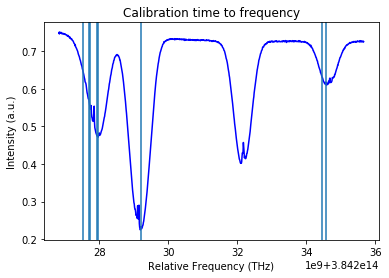

(array([  1,  19,  22,  40,  43, 142, 282, 294], dtype=int64),)


In [162]:
# calibration time and frequency
# the most distant 2 lines are the transition of Rb87 (left)F=2->F'=1, (right)F=1->F'=2
left = 1e12*384.2304844686-1e6*229.8519-1e9*2.5630060
right = 1e12*384.2304844686-72.9112*1e6+4.2716763*1e9
dif = right - left

# time, intensity and derivative of intensity
t_all,I_all,I_abl_all=np.loadtxt('Part I/All_Peaks.txt',skiprows=1,usecols=(0,1,2),unpack=True)

# find out maxima of curve
x = sgn.argrelmax(I_all)
y = t_all[x][np.where(I_all[x] < 0.65)]
z = I_all[x][np.where(I_all[x] < 0.65)]
# the left line corresponds to the first maximum, the right line corresponds to the last maximum
# according to that we can do calibration
diff = y[-1]-y[0]
t_all = (dif / diff * (t_all - y[0]) + left)
temp = t_all[np.where(I_all < 0.65)]
v = I_abl_all[np.where(I_all < 0.65)]

plt.plot(t_all, I_all, color="blue", label="data")
#m = (dif / diff * (y - y[0]) + left)
#plt.axvline(m[0])
#plt.axvline(m[-1])
for i in range(np.size(np.where(np.abs(v)<30.))):
    plt.axvline(temp[np.where(np.abs(v)<30.)][i])
#plt.axis([27e9+3.842e14,29e9+3.842e14,0.4,0.7])
plt.title("Calibration time to frequency")
plt.xlabel("Relative Frequency (THz)")
plt.ylabel("Intensity (a.u.)")
plt.show()
print(np.where(np.abs(v)<30.))

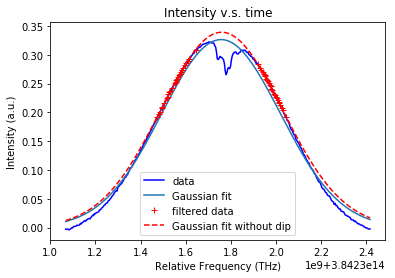

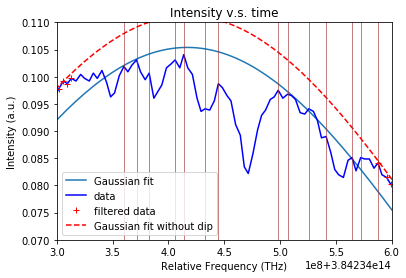

In [183]:
t,I,I_abl=np.loadtxt('Part I/Rb85_F2-Rb87_F1.txt',skiprows=1,usecols=(0,1,2),unpack=True)
t = (dif / diff * (t - y[0]) + left) # calibration

# Fit the data using a Gaussian
g_init0 = models.Gaussian1D(amplitude=0.3, mean=(dif / diff * (0.003 - y[0]) + left), stddev=0.5e9)
g_init1 = models.Gaussian1D(amplitude=0.1, mean=(dif / diff * (0.52 - y[0]) + left), stddev=0.5e9)
fit_g = fitting.LevMarLSQFitter()
t0 = t[0:350]
I0 = (I[0:350]-0.75)*(-1)
I_abl0 = I_abl[0:350]
t1 = t[700:]
I1 = (I[700:]-0.75)*(-1)
I_abl1 = I_abl[700:]
g0 = fit_g(g_init0, t0, I0)
g1 = fit_g(g_init1, t1, I1)

or_fit = fitting.FittingWithOutlierRemoval(fit_g, sigma_clip, niter = 3, sigma_lower = 1.4)
filt_data0, better_fit_g0 = or_fit(g_init0, t0, I0)
filt_data1, better_fit_g1 = or_fit(g_init1, t1, I1)

v1sign = np.sign(I_abl1)
signchange = ((np.roll(v1sign, 1) - v1sign) != 0).astype(int)
I12 = I1[np.where(signchange)]
t12 = t1[np.where(signchange)]

plt.plot(t0, I0, color="blue", label="data")
plt.plot(t0, g0(t0), label='Gaussian fit')
plt.plot(t0, filt_data0, 'r+', label="filtered data")
plt.plot(t0, better_fit_g0(t0), 'r--',label="Gaussian fit without dip")
x0 = sgn.argrelmin(I0)
y0 = t0[x0][np.where(I0[x0] > 0.25)]
#plt.axvline(y0[3])
plt.xlabel("Relative Frequency (THz)")
plt.ylabel("Intensity (a.u.)")
plt.title("Intensity v.s. time")
plt.legend()
plt.show()

plt.plot(t1, g1(t1), label='Gaussian fit')
plt.plot(t1, I1, color="blue", label="data")
plt.plot(t1, filt_data1, 'r+', label="filtered data")
plt.plot(t1, better_fit_g1(t1), 'r--',label="Gaussian fit without dip")
#ahh = t12[np.where(I12 > 0.08)]
#for i in range(np.size(ahh)):
#    plt.axvline(ahh[i], linewidth = 1, color = "green")
xx = sgn.argrelmax(I1)
yy = t1[xx][np.where((t1[xx] > 3.5e8+3.84234e14)&(t1[xx] < 6.0e8+3.84234e14))]
for i in range(np.size(yy)):
    plt.axvline(yy[i], linewidth = 0.6, color = "brown")
plt.xlabel("Relative Frequency (THz)")
plt.ylabel("Intensity (a.u.)")
plt.axis([4.3e9+3.8423e14, 4.6e9+3.8423e14, 0.07, 0.11])
plt.title("Intensity v.s. time")
plt.legend()
plt.show()

In [85]:
# theoretical transition frequency
left2 = 1e12*384.2304844686 - 1e6*72.9112 - 1e9*2.5630060 #Rb87 F=2->F'=2
left3 = 1e12*384.2304844686 + 1e6*193.7407 - 1e9*2.5630060 #Rb87 F=2->F'=3
right1 = 1e12*384.2304844686 + 1e9*4.2716766 - 1e6*229.8519 #Rb87 F=1->F'=1
right0 = 1e12*384.2304844686 + 1e9*4.2716766 - 1e6*302.0739 #Rb87 F=1->F'=0
midleft2 = 1e12*384.2304063731 - 1e9*1.2648852 - 1e6*83.8353 #Rb85 F=3->F'=2
midleft3 = 1e12*384.2304063731 - 1e9*1.2648852 - 1e6*20.4355 #Rb85 F=3->F'=3
midleft4 = 1e12*384.2304063731 - 1e9*1.2648852 + 1e6*100.2054 #Rb85 F=3->F'=4
midright1 = 1e12*384.2304063731 + 1e9*1.7708439 -1e6*113.2088 #Rb85 F=2->F'=1
midright2 = 1e12*384.2304063731 + 1e9*1.7708439 -1e6*83.8353 #Rb85 F=2->F'=2
midright3 = 1e12*384.2304063731 + 1e9*1.7708439 -1e6*20.4355 #Rb85 F=2->F'=3
print("Theoretical transition frequency, lines from left to right")
print(left,"|",left2,"|",left3,"|",midleft2,"|",midleft3,"|",midleft4,"|")
print(midright1,"|",midright2,"|",midright3,"|",right0,"|",right1,"|",right,"|")
# measurement of transition frequency


384227691610700.0 | 384227848551400.0 | 384228115203300.0 | 384229057652600.0 | 384229121052400.0 | 384229241693300.0 |
384232064008200.0 | 384232093381700.0 | 384232156781500.0 | 384234454071300.0 | 384234526293300.0 | 384234683233700.0 |
